# Анализ деловых циклов по данным World Bank’s WDI

В этом блокноте анализируются данные для определения, насколько применимы к реальным данным факты, обсуждаемые в первой главе Martin Uribe, Open Economy Macroeconomics.

В качестве реальных данных взяты:
1. ВВП на душу населения (в локальной валюте)
1. Расходы домохозяйств и некоммерческих организаций на конечное потребление (% от ВВП)
1. Валовое накопление капитала (% от ВВП)
1. Объём государственных расходов на конечное потребление (% от ВВП)
1. Общий объём импорта товаров и услуг (% от ВВП)
1. Общий объём экспорта товаров и услуг (% от ВВП)

Взятые страны: Центральная Африканская республика (бедная), Греция (развивающаяся), США (богатая)

### Импорт библиотек для анализа

In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter

### Чтение данных

Также уберём метаданные

In [388]:
raw_df = pd.read_csv('data.csv')
raw_df = raw_df.iloc[:-5]

raw_df

,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Greece,GRC,GDP per capita (constant LCU),NY.GDP.PCAP.KN,4464.8581176167,5014.47288358607,5002.87136966985,5574.74015655173,6077.22842173996,6700.20886905808,...,16033.0004012885,16102.1387995786,16164.1081810632,16434.6986088567,16808.0869611722,17208.9557306002,15659.9493073813,17223.5459103034,18443.7187274897,18930.6108410212
1,Greece,GRC,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,..,..,..,..,..,..,...,26450.181326726,26614.8483754225,27504.5497984948,28681.6815585005,29792.0592519585,31927.3792151369,29533.087740299,33531.15511226,38969.0221675373,41181.9912164324
2,Greece,GRC,Households and NPISHs final consumption expend...,NE.CON.PRVT.ZS,74.9743600644054,70.8930378982755,71.5567889804874,68.7646539327248,67.950635364173,65.8186851542815,...,69.5329655860989,68.6886594094333,68.0126932819622,68.8100060538919,68.8330418045266,68.3649191955026,69.1479743901376,67.0716816185717,68.0652905785852,66.8996651467981
3,Greece,GRC,Gross capital formation (% of GDP),NE.GDI.TOTL.ZS,15.2152426095875,20.5512940761309,21.6209766692666,25.0513864574215,29.3079210690835,32.1589823023432,...,12.136918450953,12.0084097844243,12.4680861540635,11.8883016329317,12.9530537485632,12.0996603246177,13.5410023084822,17.48296657419,19.9840681581658,16.7312327593368
4,Greece,GRC,General government final consumption expenditu...,NE.CON.GOVT.ZS,12.4644627835671,11.8509885497247,12.3297810989905,11.7579248468176,12.1239020582414,12.1047837901808,...,20.7227080595732,20.7679837462522,20.6180603140124,20.4384126534599,19.6597104516787,19.9791204523634,22.7274940590434,21.4974385558012,19.9856875626536,19.2868439733478
5,Greece,GRC,Imports of goods and services (% of GDP),NE.IMP.GNFS.ZS,13.9746948449116,13.5441527446301,14.1555396958321,14.6484619232212,16.0350443321509,16.3236690804828,...,33.9185692513027,33.085423586627,32.4782765724963,36.1032862068475,40.6071874522328,41.0298090980773,38.8433569445986,47.7522509396405,58.6593231211582,48.4480311941784
6,Greece,GRC,Exports of goods and services (% of GDP),NE.EXP.GNFS.ZS,9.86566267941313,9.44717364857963,8.31788483336611,9.03639646117294,7.61728936615559,7.62209645477615,...,32.514999005264,32.1863775524943,31.1793860165412,34.7793204673102,38.630976154138,39.5602917930958,31.450429504041,40.2604118004654,49.019884781247,43.7082588320458
7,Greece,GRC,Current account balance (% of GDP),BN.CAB.XOKA.GD.ZS,..,..,..,..,..,..,...,-1.59663409250033,-0.82819219779973,-1.68881636338714,-1.79956830770948,-2.92946837177349,-1.50121840629263,-6.48664200392794,-6.34795283469094,-10.3357101038964,-6.16330418209365
8,United States,USA,GDP per capita (constant LCU),NY.GDP.PCAP.KN,19373.7345783219,19544.0495179405,20425.4575475238,21010.8855328098,21915.1540734487,23049.3353164902,...,57200.5687195003,58417.4601292274,59014.8755674907,60047.7190728307,61467.5128626242,62731.7557063691,61124.6889567852,64723.9191018988,65969.117811109,67311.9850921048
9,United States,USA,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,..,..,..,..,..,..,...,55153.3940182967,56849.4697923159,57976.628204291,60047.7190728307,62875.6661382728,65227.9565911035,64401.5074354209,71307.4017277218,77860.9112908848,82304.6204272866


### Подготовка данных
Здесь:
1. разделим данные по странам
1. поменяем столбы местами с колонками
1. укоротим название колонок

In [389]:
usa_df = raw_df[raw_df['Country Name'] == 'United States']
usa_df = usa_df.drop(columns=['Country Name', 'Country Code', 'Series Code'])

greece_df = raw_df[raw_df['Country Name'] == 'Greece']
greece_df = greece_df.drop(columns=['Country Name', 'Country Code', 'Series Code'])

car_df = raw_df[raw_df['Country Name'] == 'Central African Republic']
car_df = car_df.drop(columns=['Country Name', 'Country Code', 'Series Code'])

usa_df

,Series Name,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],1966 [YR1966],1967 [YR1967],1968 [YR1968],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
8,GDP per capita (constant LCU),19373.7345783219,19544.0495179405,20425.4575475238,21010.8855328098,21915.1540734487,23049.3353164902,24287.3982498983,24683.2803252949,25639.0641037139,...,57200.5687195003,58417.4601292274,59014.8755674907,60047.7190728307,61467.5128626242,62731.7557063691,61124.6889567852,64723.9191018988,65969.117811109,67311.9850921048
9,"GDP per capita, PPP (current international $)",..,..,..,..,..,..,..,..,..,...,55153.3940182967,56849.4697923159,57976.628204291,60047.7190728307,62875.6661382728,65227.9565911035,64401.5074354209,71307.4017277218,77860.9112908848,82304.6204272866
10,Households and NPISHs final consumption expend...,61.0593318290393,60.6914772523262,59.9535682851458,59.8443672268638,59.8910560099553,59.579118683332,58.9521662793762,58.8664027840917,59.1364567937584,...,67.4372838286479,67.2174103782018,67.6783189584552,67.7674733692493,67.4578520404893,67.0267180353261,66.6179032087741,68.0453893095067,68.0236620345229,67.9014703411807
11,Gross capital formation (% of GDP),22.5817018592685,22.479885011645,23.0803965716589,23.140103957718,23.1234969557422,23.8745255337027,24.2919004972596,23.2786512192839,22.956778219539,...,20.9011935276745,21.4151895660781,20.8879562484549,21.1557690246563,21.5690729259474,21.6698091948266,21.4188185362955,21.3332820408248,21.9497730851586,21.5410327347688
12,General government final consumption expenditu...,15.5823164085842,15.87869266483,16.1543263149681,16.0961900202767,15.8060103227583,15.6273583261651,16.1995957330124,17.3514062105728,17.6585700251883,...,14.5516578754664,14.2333167295426,14.1100041249858,13.8471337748498,13.8442126445718,13.9835585749329,14.8957448696632,14.2530325041781,13.7137950311865,13.4338338893136
13,Imports of goods and services (% of GDP),4.21117277102206,4.03241301969625,4.1282910886803,4.09395091411542,4.09899432607246,4.24059713112712,4.55199820347776,4.63695563894464,4.94414473233501,...,16.3983551242045,15.2770653039497,14.5644385592212,14.9478571955214,15.1582483706352,14.4692832148142,13.0061222420701,14.422677831261,15.2894619130397,13.8878518583345
14,Exports of goods and services (% of GDP),4.98626012837842,4.9057944362507,4.80644537486808,4.86762696404143,5.10755345519255,4.99607412327851,5.02652040063443,5.04997371111462,5.08751176104564,...,13.5082142132235,12.4111486301271,11.8881592273253,12.177481026766,12.2871107596266,11.7891974097286,10.0736556273372,10.7909781995156,11.6022279170372,11.0115112856601
15,Current account balance (% of GDP),..,..,..,..,..,..,..,..,..,...,-2.10117617206317,-2.2325584903738,-2.10699725119707,-1.87442427129943,-2.12518413076048,-2.05182158462342,-2.77934383108072,-3.62580887575196,-3.81876450985514,-3.34773904953152


In [390]:
def transpose_rename_df(df):
    year_columns = [col for col in df.columns if '[YR' in col]
    
    melted_df = df[['Series Name'] + year_columns].copy()
    # Уберём '[YR****]' из имени года
    melted_df.columns = [col.split(' [YR')[0] if '[YR' in col else col for col in melted_df.columns]
    melted_df = melted_df.melt(id_vars=['Series Name'], 
                          var_name='Year', 
                          value_name='Value')
    
    final_df = melted_df.pivot(index='Year', 
                          columns='Series Name', 
                          values='Value')
    final_df.index = pd.to_numeric(final_df.index)

    column_mapping = {
        'GDP per capita (constant LCU)': 'gdp_per_capita',
        'GDP per capita, PPP (current international $)': 'gdp_ppp',
        'Households and NPISHs final consumption expenditure (% of GDP)': 'house_consumption',
        'Gross capital formation (% of GDP)': 'investment',
        'General government final consumption expenditure (% of GDP)': 'gov_spending',
        'Imports of goods and services (% of GDP)': 'import',
        'Exports of goods and services (% of GDP)': 'export',
        'Current account balance (% of GDP)': "current_account"
    }
    final_df = final_df.rename(columns=column_mapping)
    
    final_df = final_df.replace('..', np.nan)
    final_df = final_df.astype(float)
    
    return final_df

In [391]:
usa_df = transpose_rename_df(usa_df)
greece_df = transpose_rename_df(greece_df)
car_df = transpose_rename_df(car_df)

usa_df

Series Name,current_account,export,gdp_per_capita,gdp_ppp,gov_spending,investment,house_consumption,import
Year,,,,,,,,
1960,NaN,4.986260,19373.734578,NaN,15.582316,22.581702,61.059332,4.211173
1961,NaN,4.905794,19544.049518,NaN,15.878693,22.479885,60.691477,4.032413
1962,NaN,4.806445,20425.457548,NaN,16.154326,23.080397,59.953568,4.128291
1963,NaN,4.867627,21010.885533,NaN,16.096190,23.140104,59.844367,4.093951
1964,NaN,5.107553,21915.154073,NaN,15.806010,23.123497,59.891056,4.098994
...,...,...,...,...,...,...,...,...
2019,-2.051822,11.789197,62731.755706,65227.956591,13.983559,21.669809,67.026718,14.469283
2020,-2.779344,10.073656,61124.688957,64401.507435,14.895745,21.418819,66.617903,13.006122
2021,-3.625809,10.790978,64723.919102,71307.401728,14.253033,21.333282,68.045389,14.422678


### Вычисление статистик
Вычислим абсолютные значения всех данных (перевёд проценты в валюту), а также вычислим тороговый баланс и сальдо торговых операций?

In [392]:
gdp_name = 'gdp_per_capita'

In [393]:
def prepare_statistics(df):
    df['house_consumption'] = (df['house_consumption'] / 100) * df[gdp_name]
    df['gov_spending'] = (df['gov_spending'] / 100) * df[gdp_name]
    df['gov_spending_share'] = df['gov_spending'] / df[gdp_name]
    df['investment'] = (df['investment'] / 100) * df[gdp_name]
    df['import'] = (df['import'] / 100) * df[gdp_name]
    df['export'] = (df['export'] / 100) * df[gdp_name]
    df['current_account'] = (df['current_account'] / 100) * df[gdp_name]
    df['current_account_share'] = df['current_account'] / df[gdp_name]

    df['trade_balance'] = df['export'] - df['import']
    df['trade_balance_share'] = df['trade_balance'] / df[gdp_name]

    df['international_share'] = (df['export'] + df['import']) / df[gdp_name]

    df[f'ln_{gdp_name}'] = np.log(df[gdp_name])
    df['ln_house_consumption'] = np.log(df['house_consumption'])
    df['ln_gov_spending'] = np.log(df['gov_spending'])
    df['ln_investment'] = np.log(df['investment'])
    df['ln_export'] = np.log(df['export'])
    df['ln_import'] = np.log(df['import'])

prepare_statistics(usa_df)
prepare_statistics(greece_df)
prepare_statistics(car_df)

usa_df

Series Name,current_account,export,gdp_per_capita,gdp_ppp,gov_spending,investment,house_consumption,import,gov_spending_share,current_account_share,trade_balance,trade_balance_share,international_share,ln_gdp_per_capita,ln_house_consumption,ln_gov_spending,ln_investment,ln_export,ln_import
Year,,,,,,,,,,,,,,,,,,,
1960,NaN,966.024803,19373.734578,NaN,3018.876622,4374.918981,11829.472884,815.861435,0.155823,NaN,150.163367,0.007751,0.091974,9.871674,9.378349,8.012640,8.383643,6.873190,6.704245
1961,NaN,958.790894,19544.049518,NaN,3103.339557,4393.479858,11861.572367,788.096797,0.158787,NaN,170.694097,0.008734,0.089382,9.880426,9.381059,8.040234,8.387877,6.865673,6.669621
1962,NaN,981.738460,20425.457548,NaN,3299.595064,4714.276604,12245.790638,843.222344,0.161543,NaN,138.516116,0.006782,0.089347,9.924537,9.412938,8.101555,8.458351,6.889325,6.737231
1963,NaN,1022.731530,21010.885533,NaN,3381.952060,4861.940755,12573.831496,860.175340,0.160962,NaN,162.556189,0.007737,0.089616,9.952796,9.439373,8.126208,8.489193,6.930232,6.757136
1964,NaN,1119.328209,21915.154073,NaN,3463.911515,5067.549985,13125.217201,898.300922,0.158060,NaN,221.027287,0.010086,0.092065,9.994934,9.482291,8.150154,8.530613,7.020484,6.800505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,-1287.143704,7395.570519,62731.755706,65227.956591,8772.131804,13593.851766,42047.037016,9076.835399,0.139836,-0.020518,-1681.264880,-0.026801,0.262585,11.046623,10.646544,9.079335,9.517373,8.908637,9.113481
2020,-1698.865272,6157.490669,61124.688957,64401.507435,9104.977719,13092.186209,40719.986126,7949.951766,0.148957,-0.027793,-1792.461097,-0.029325,0.230798,11.020671,10.614474,9.116577,9.479771,8.725425,8.980921
2021,-2346.765604,6984.344000,64723.919102,71307.401728,9225.121228,13807.736210,44041.642729,9334.922332,0.142530,-0.036258,-2350.578332,-0.036317,0.252137,11.077886,10.692891,9.129686,9.532984,8.851426,9.141518


### Выделение циклической компоненты

In [394]:
detrended_names_in_levels = [
    'current_account_share',
    'trade_balance_share',
    'gov_spending_share',
    'international_share']

detrended_names_scaled_in_levels = [
    'current_account',
    'trade_balance']

detrended_names_in_logs = [gdp_name, 'gov_spending', 'investment', 'house_consumption', 'export', 'import']

detrended_names = detrended_names_in_levels + detrended_names_in_logs

Функции берут колонку со статистикой и возвращают две колонки: модель тренда и циклическую компоненту

In [395]:
def log_linear_detrending(series):
    series = series.dropna()
    trend = np.arange(len(series))
    X = sm.add_constant(trend)
    model = sm.OLS(series, X).fit()
    trend_component = pd.Series(model.fittedvalues, index=series.index)
    cyclical_component = series - trend_component
        
    return trend_component, cyclical_component

In [396]:
def log_quadratic_detrending(series):
    series = series.dropna()
    trend = np.arange(len(series))
    trend_sq = trend ** 2
    X = sm.add_constant(np.column_stack([trend, trend_sq]))
    model = sm.OLS(series, X).fit()
    trend_component = pd.Series(model.fittedvalues, index=series.index)
    cyclical_component = series - trend_component
    
    return trend_component, cyclical_component

In [397]:
def hp_filter_detrending(series, lamb=100):
    series = series.dropna()
    cyclical, trend = hpfilter(series, lamb=lamb)
    trend_component = pd.Series(trend, index=series.index)
    cyclical_component = pd.Series(cyclical, index=series.index)
    
    return trend_component, cyclical_component

In [398]:
method_names = ['linear', 'quadratic', 'hp100', 'hp625']

Применить модели для каждой рассматриваемой статистики

In [399]:
def compute_all_detrending(df):
    result_df = df.copy()
    for statistic_name in detrended_names:
        if statistic_name in detrended_names_in_levels:
            statistic = result_df[statistic_name]
        else:
            statistic = result_df[f'ln_{statistic_name}']
            
        trend_linear, cyclical_linear = log_linear_detrending(statistic)
        result_df[f'{statistic_name}_linear_cyclical'] = cyclical_linear
        result_df[f'{statistic_name}_linear_trend'] = trend_linear
        
        trend_quad, cyclical_quad = log_quadratic_detrending(statistic)
        result_df[f'{statistic_name}_quadratic_cyclical'] = cyclical_quad
        result_df[f'{statistic_name}_quadratic_trend'] = trend_quad
        
        trend_hp100, cyclical_hp100  = hp_filter_detrending(statistic, lamb=100)
        result_df[f'{statistic_name}_hp100_cyclical'] = cyclical_hp100
        result_df[f'{statistic_name}_hp100_trend'] = trend_hp100
        
        trend_hp625, cyclical_hp625  = hp_filter_detrending(statistic, lamb=6.25)
        result_df[f'{statistic_name}_hp625_cyclical'] = cyclical_hp625
        result_df[f'{statistic_name}_hp625_trend'] = trend_hp625

    for statistic_name in detrended_names_scaled_in_levels:
        statistic = result_df[statistic_name] / np.exp(result_df[f'{gdp_name}_linear_trend'])
        trend_linear, cyclical_linear = log_linear_detrending(statistic)
        result_df[f'{statistic_name}_linear_cyclical'] = cyclical_linear
        result_df[f'{statistic_name}_linear_trend'] = trend_linear
        
        statistic = result_df[statistic_name] / np.exp(result_df[f'{gdp_name}_quadratic_trend'])
        trend_quad, cyclical_quad = log_quadratic_detrending(statistic)
        result_df[f'{statistic_name}_quadratic_cyclical'] = cyclical_quad
        result_df[f'{statistic_name}_quadratic_trend'] = trend_quad
        
        statistic = result_df[statistic_name] / np.exp(result_df[f'{gdp_name}_hp100_trend'])
        trend_hp100, cyclical_hp100  = hp_filter_detrending(statistic, lamb=100)
        result_df[f'{statistic_name}_hp100_cyclical'] = cyclical_hp100
        result_df[f'{statistic_name}_hp100_trend'] = trend_hp100
        
        statistic = result_df[statistic_name] / np.exp(result_df[f'{gdp_name}_hp625_trend'])
        trend_hp625, cyclical_hp625  = hp_filter_detrending(statistic, lamb=6.25)
        result_df[f'{statistic_name}_hp625_cyclical'] = cyclical_hp625
        result_df[f'{statistic_name}_hp625_trend'] = trend_hp625
        
    return result_df

In [400]:
usa_dedf = compute_all_detrending(usa_df)
greece_dedf = compute_all_detrending(greece_df)
car_dedf = compute_all_detrending(car_df)
usa_dedf

c:\Users\amath\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\amath\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\amath\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\amath\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_u

Series Name,current_account,export,gdp_per_capita,gdp_ppp,gov_spending,investment,house_consumption,import,gov_spending_share,current_account_share,...,current_account_hp625_cyclical,current_account_hp625_trend,trade_balance_linear_cyclical,trade_balance_linear_trend,trade_balance_quadratic_cyclical,trade_balance_quadratic_trend,trade_balance_hp100_cyclical,trade_balance_hp100_trend,trade_balance_hp625_cyclical,trade_balance_hp625_trend
Year,,,,,,,,,,,,,,,,,,,,,
1960,NaN,966.024803,19373.734578,NaN,3018.876622,4374.918981,11829.472884,815.861435,0.155823,NaN,...,NaN,NaN,0.000106,0.006832,-0.007832,0.015411,-0.001136,0.008923,-0.000375,0.008227
1961,NaN,958.790894,19544.049518,NaN,3103.339557,4393.479858,11861.572367,788.096797,0.158787,NaN,...,NaN,NaN,0.001702,0.006037,-0.005475,0.013858,0.000132,0.008420,0.000449,0.008188
1962,NaN,981.738460,20425.457548,NaN,3299.595064,4714.276604,12245.790638,843.222344,0.161543,NaN,...,NaN,NaN,0.000921,0.005242,-0.005708,0.012329,-0.001201,0.007906,-0.001320,0.008089
1963,NaN,1022.731530,21010.885533,NaN,3381.952060,4861.940755,12573.831496,860.175340,0.160962,NaN,...,NaN,NaN,0.002650,0.004448,-0.003259,0.010824,0.000232,0.007370,-0.000288,0.007942
1964,NaN,1119.328209,21915.154073,NaN,3463.911515,5067.549985,13125.217201,898.300922,0.158060,NaN,...,NaN,NaN,0.005817,0.003653,0.000675,0.009342,0.003201,0.006791,0.002456,0.007547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,-1287.143704,7395.570519,62731.755706,65227.956591,8772.131804,13593.851766,42047.037016,9076.835399,0.139836,-0.020518,...,0.003728,-0.024488,0.014594,-0.040069,0.008637,-0.035584,0.002444,-0.029551,0.002229,-0.029345
2020,-1698.865272,6157.490669,61124.688957,64401.507435,9104.977719,13092.186209,40719.986126,7949.951766,0.148957,-0.027793,...,0.000928,-0.027878,0.014212,-0.040864,0.007330,-0.035737,0.001503,-0.029914,0.002278,-0.030714
2021,-2346.765604,6984.344000,64723.919102,71307.401728,9225.121228,13807.736210,44041.642729,9334.922332,0.142530,-0.036258,...,-0.004963,-0.031529,0.007363,-0.041659,-0.000978,-0.035865,-0.006209,-0.030396,-0.004423,-0.032128


### Анализ статистик

In [375]:
short_names = {
    gdp_name: 'y',
    'trade_balance': 'tb',
    'trade_balance_share': 'tb/y',
    'current_account': 'ca',
    'current_account_share': 'ca/y',
    'international_share': '(x + m)/y',
    'gov_spending': 'g',
    'gov_spending_share': 'g/y',
    'investment': 'i',
    'house_consumption': 'с',
    'export': 'x',
    'import': 'm'
}

Посчитаем отклонения

In [376]:
simple_deviation_statistics_names = [gdp_name, 'trade_balance_share', 'current_account_share']

relative_deviation_statistics_names = [
    'house_consumption', 'gov_spending', 'investment', 'export', 'import']

In [402]:
def calculate_business_cycle_stds(df):
    stats_data = []
    
    for method in method_names:
        for statictic in simple_deviation_statistics_names:
            column_name = f'{statictic}_{method}_cyclical'
            series = df[column_name]
            
            std = np.std(series) * 100
            stats_dict = {
                'Statistic': f'σ_{short_names[statictic]}',
                'Method': method,
                'Std_Dev': std
            }
            stats_data.append(stats_dict)

            if statictic == gdp_name:
                gdp_std = std

        for statictic in relative_deviation_statistics_names:
            column_name = f'{statictic}_{method}_cyclical'
            series = df[column_name]
            
            std = np.std(series) * 100
            stats_dict = {
                'Statistic': f'σ_{short_names[statictic]}/σ_{short_names[gdp_name]}',
                'Method': method,
                'Std_Dev': std / gdp_std
            }
            stats_data.append(stats_dict)
    
    stats_df = pd.DataFrame(stats_data)
    result_df = stats_df.pivot(index='Statistic',
                               columns='Method',
                               values='Std_Dev')
    
    return result_df

usa_stds = calculate_business_cycle_stds(usa_dedf)
greece_stds = calculate_business_cycle_stds(greece_dedf)
car_stds = calculate_business_cycle_stds(car_dedf)
usa_stds

Method,hp100,hp625,linear,quadratic
Statistic,,,,
σ_ca/y,0.692635,0.397365,1.272368,1.131721
σ_g/σ_y,1.373545,0.866080,1.473698,1.926053
σ_i/σ_y,3.225244,3.316558,1.806207,2.768973
σ_m/σ_y,3.355746,3.897908,4.166386,3.329795
σ_tb/y,0.553907,0.338480,1.041901,0.979839
σ_x/σ_y,3.919621,3.772256,3.168808,3.579349
σ_y,1.879986,1.301896,4.984899,2.786864
σ_с/σ_y,0.917662,0.867540,1.065712,1.071046


In [412]:
greece_stds

Method,hp100,hp625,linear,quadratic
Statistic,,,,
σ_ca/y,2.083181,1.303579,3.344194,3.296652
σ_g/σ_y,1.180631,1.186271,1.251424,1.119397
σ_i/σ_y,3.159957,3.617904,2.078711,2.575423
σ_m/σ_y,2.086548,2.725990,1.201460,1.572528
σ_tb/y,1.435468,1.001189,2.541158,2.329591
σ_x/σ_y,2.410230,3.388568,1.324348,1.970559
σ_y,4.217187,2.295294,19.454127,11.437482
σ_с/σ_y,0.876551,0.810748,0.821218,0.666180


In [413]:
car_stds

Method,hp100,hp625,linear,quadratic
Statistic,,,,
σ_ca/y,1.669925,1.524963,1.869431,1.679368
σ_g/σ_y,2.178903,1.979017,2.237448,2.313703
σ_i/σ_y,3.258184,3.579953,4.422488,3.111248
σ_m/σ_y,1.514135,1.709517,2.276715,2.138156
σ_tb/y,2.858716,2.448844,5.062763,4.010150
σ_x/σ_y,1.601963,1.816287,1.692445,1.740041
σ_y,6.373114,4.502742,8.583066,8.218528
σ_с/σ_y,1.230029,1.260693,1.488560,1.499924


Посчитаем корреляцию

In [405]:
correlation_statistics_names = [gdp_name, 'house_consumption', 'gov_spending_share',
                                'investment', 'export', 'import',
                                'trade_balance_share', 'trade_balance',
                                'current_account_share', 'current_account']

In [406]:
def calculate_business_cycle_correlations(df):
    corr_data = []
    
    for method in method_names:
        gdp = df[f'{gdp_name}_{method}_cyclical']
        
        for statistic_name in correlation_statistics_names:
            statistic = df[f'{statistic_name}_{method}_cyclical']
            
            correlation = gdp.corr(statistic)
            corr_dict = {
                'Statistic': short_names[statistic_name],
                'Method': method,
                'Correlation': correlation
            }
            corr_data.append(corr_dict)
    
    corr_df = pd.DataFrame(corr_data)
    result_df = corr_df.pivot(index='Statistic',
                              columns='Method',
                              values='Correlation')
    
    return result_df

usa_corr = calculate_business_cycle_correlations(usa_dedf)
greece_corr = calculate_business_cycle_correlations(greece_dedf)
car_corr = calculate_business_cycle_correlations(car_dedf)

usa_corr

Method,hp100,hp625,linear,quadratic
Statistic,,,,
ca,-0.564424,-0.488685,-0.682362,-0.679929
ca/y,-0.541838,-0.467013,-0.657587,-0.657882
g/y,-0.522784,-0.803342,0.054809,-0.128577
i,0.865881,0.914654,0.790983,0.759268
m,0.628699,0.714164,0.806915,0.260828
tb,-0.598135,-0.560123,-0.559588,-0.497947
tb/y,-0.575486,-0.538699,-0.529130,-0.470268
x,0.139218,0.424531,0.588306,-0.154611
y,1.000000,1.000000,1.000000,1.000000


Посчитаем автокорреляцию

In [407]:
autocorrelation_statistics_names = [gdp_name, 'house_consumption', 'gov_spending',
                                'investment', 'export', 'import',
                                'trade_balance_share', 'current_account_share']

In [408]:
def calculate_business_cycle_autocorrelations(df):
    autocorr_data = []
    
    for method in method_names:
        for statistic_name in autocorrelation_statistics_names:
            column_name = f'{statistic_name}_{method}_cyclical'
            series = df[column_name]
            
            autocorr = series.autocorr(lag=1)
            
            autocorr_dict = {
                'Statistic': short_names[statistic_name],
                'Method': method,
                'Autocorrelation': autocorr
            }
            autocorr_data.append(autocorr_dict)
    
    autocorr_df = pd.DataFrame(autocorr_data)
    result_df = autocorr_df.pivot(index='Statistic',
                                 columns='Method',
                                 values='Autocorrelation')
    
    return result_df

usa_autocorr = calculate_business_cycle_autocorrelations(usa_dedf)
greece_autocorr = calculate_business_cycle_autocorrelations(greece_dedf)
car_autocorr = calculate_business_cycle_autocorrelations(car_dedf)

usa_autocorr

Method,hp100,hp625,linear,quadratic
Statistic,,,,
ca/y,0.663498,0.242965,0.875962,0.842527
g,0.816355,0.476477,0.952578,0.927105
i,0.517939,0.258297,0.757003,0.674880
m,0.256365,0.010179,0.920165,0.631427
tb/y,0.605049,0.170594,0.862876,0.846806
x,0.566942,0.248915,0.887516,0.735167
y,0.527313,0.231239,0.917071,0.756200
с,0.536241,0.154545,0.939714,0.823149


Посчитаем среднее

In [409]:
means_statistics_names = ['trade_balance_share', 'international_share']

In [410]:
def calculate_business_cycle_means(df):
    means_data = []
    
    for method in method_names:
        for statistic_name in means_statistics_names:
            statistic = df[f'{statistic_name}_{method}_trend']
            
            
            mean = np.mean(statistic) * 100
            mean_dict = {
                'Statistic': short_names[statistic_name],
                'Method': method,
                'Mean': mean
            }
            means_data.append(mean_dict)
    
    corr_df = pd.DataFrame(means_data)
    result_df = corr_df.pivot(index='Statistic',
                              columns='Method',
                              values='Mean')
    
    return result_df

use_means = calculate_business_cycle_means(usa_dedf)
greece_means = calculate_business_cycle_means(greece_dedf)
car_means = calculate_business_cycle_means(car_dedf)

use_means

Method,hp100,hp625,linear,quadratic
Statistic,,,,
(x + m)/y,19.897712,19.897712,19.897712,19.897712
tb/y,-1.791013,-1.791013,-1.791013,-1.791013


### Визуализация ВВП и трендов

Сравним исходный ВВП на душу населения с трендами, полученными разными методами

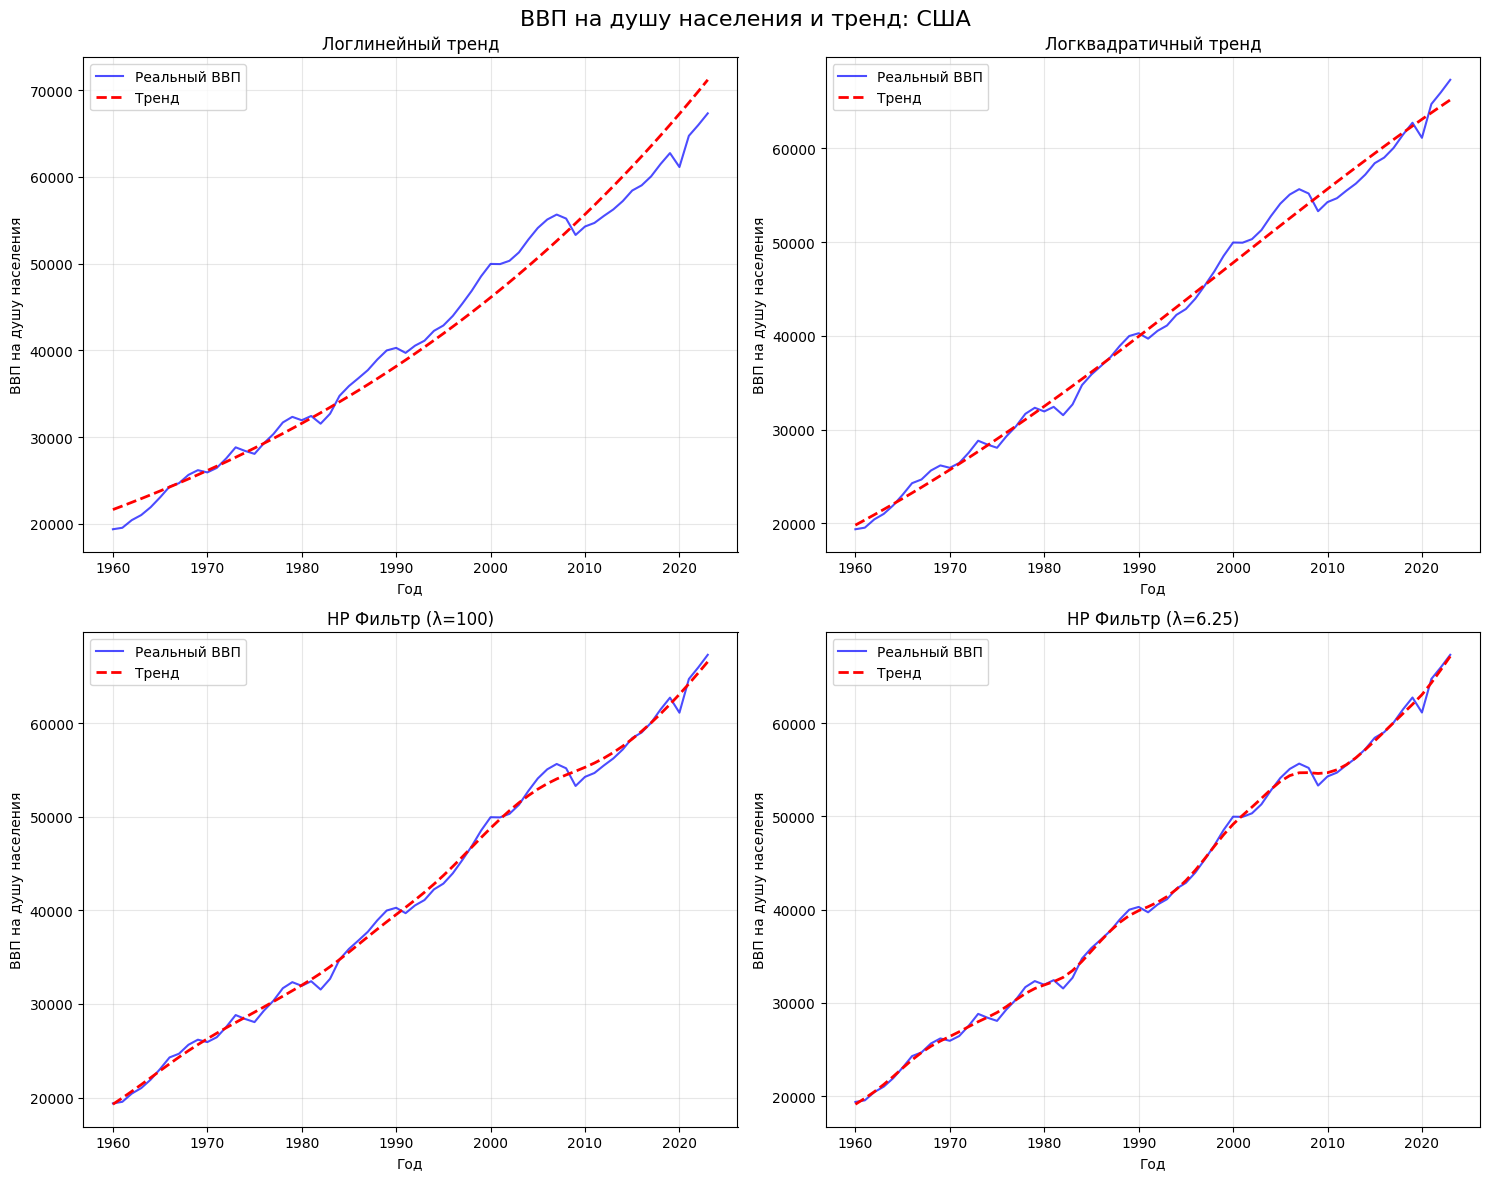

In [ ]:
def plot_gdp_trends(df, country_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'ВВП на душу населения и тренд: {country_name}', fontsize=16)
    
    ln_gdp = df[gdp_name]
    years = df.index
    
    methods = [
        ('linear', 'Логлинейный тренд'),
        ('quadratic', 'Логквадратичный тренд'),
        ('hp100', 'HP Фильтр (λ=100)'),
        ('hp625', 'HP Фильтр (λ=6.25)')
    ]
    
    for idx, (method, title) in enumerate(methods):
        ax = axes[idx//2, idx%2]
        
        ax.plot(years, ln_gdp, 'b-', label='Реальный ВВП', linewidth=1.5, alpha=0.7)
        
        trend = np.exp(df[f'{gdp_name}_{method}_trend'])
        ax.plot(years, trend, 'r--', label='Тренд', linewidth=2)
        
        ax.set_title(title)
        ax.set_xlabel('Год')
        ax.set_ylabel('ВВП на душу населения')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_gdp_trends(usa_dedf, 'США')
plot_gdp_trends(greece_dedf, 'Греция')
plot_gdp_trends(car_dedf, 'Центральная Африканская республика')